# Reinforcement Learning Orbit Optimization

This project showcases a program  a spacecraft’s autonomous mastery of orbit dynamics around procedurally generated planets. This program utilizes a reinforcemt learning loop to dictate the correct steps the spacecraft needs to take to achieve a stable orbit. The state and reward system, based on crucial parameters like gravity, speed, apoapsis, periapsis, and eccentricity, make up the learning process, with rewards maximizing upon successful orbit achievement. A combination of fuzzy logic and neural networks dictate the steps our 2D spacecraft requires to reach orbit around a procedurally generated planet. 

In [1]:
# imports for game
import pygame
import math
import numpy as np # for finding smallest/largest list items
import random

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# imports for reinforcement learning

# skfuzzy imports
import matplotlib.pyplot as plt
%matplotlib inline
import skfuzzy as fuzz

# control and rule import
from skfuzzy import control as ctrl
# adaptive neuro fuzzy
import sklearn.datasets

# for loss function
import torch
import torch.nn.functional as F

### Fuzzy logic

The 5 crisp value variables below represent the range of possible values for each one of the physics parameters below. The range of values within each one of the variables is subdivided into three caterogies: low, medium, high values. The current state of the spacecraft corresponds with each of the 5 parameters below. 

In [3]:
# defines the rules with their crisp universes(range of values)
gravity = ctrl.Antecedent(np.arange(0, 1.51, 0.01), 'gravity')
velocity = ctrl.Antecedent(np.arange(0, 2.01, 0.01), 'velocity')
apoapsis = ctrl.Antecedent(np.arange(0, 301, 1), 'apoapsis')
periapsis = ctrl.Antecedent(np.arange(0, 301, 1), 'periapsis')
eccentricity = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'eccentricity')

# defines output
maneuver = ctrl.Consequent(np.arange(0, 101, 1), 'maneuver')

In [4]:
# the variables below are based off the ideal values associated with an orbit

# defines the input variables
# gravity is measured in a factor of 1, where 1 is surface gravity (SG)
gravity['weak'] = fuzz.trapmf(gravity.universe, [0, 0, 0.4, 0.6])
gravity['moderate'] = fuzz.trapmf(gravity.universe, [0.5, 0.8, 1.1, 1.3])
gravity['strong'] = fuzz.trapmf(gravity.universe, [1.1, 1.3, 1.5, 1.5])

# the velocity is measures as a factor of 1, 1 being the orbital velocity (OF)
velocity['slow'] = fuzz.trapmf(velocity.universe, [0, 0, 0.4, 0.6])
velocity['nominal'] = fuzz.trapmf(velocity.universe, [0.4, 0.4, 1.2, 1.6])
velocity['fast'] = fuzz.trapmf(velocity.universe, [1.0, 1.2, 2.0, 2.0])

# the apoapsis represents the highest point in an orbit (M)
apoapsis['low'] = fuzz.trapmf(apoapsis.universe, [0, 0, 70, 140])
apoapsis['medium'] = fuzz.trapmf(apoapsis.universe, [120, 170, 230, 280])
apoapsis['high'] = fuzz.trapmf(apoapsis.universe, [220, 260, 300, 300])

# the periapsis represents the lowest point in an orbit (M)
periapsis['low'] = fuzz.trapmf(periapsis.universe, [0, 0, 70, 140])
periapsis['medium'] = fuzz.trapmf(periapsis.universe, [120, 170, 230, 280])
periapsis['high'] = fuzz.trapmf(periapsis.universe, [220, 260, 300, 300])

# eccentricity represents the difference between apoapsis and periapsis as a ratio of 1
eccentricity['significant'] = fuzz.trapmf(eccentricity.universe, [0, 0, 0.1, 0.2])
eccentricity['moderate'] = fuzz.trapmf(eccentricity.universe, [0.2, 0.2, 0.4, 0.8])
eccentricity['minimal'] = fuzz.trapmf(eccentricity.universe, [0.5, 0.6, 1.0, 1.0])

# defines the output variables
maneuver['no'] = fuzz.trapmf(maneuver.universe, [0, 0, 45, 55])
maneuver['yes'] = fuzz.trapmf(maneuver.universe, [45, 55, 100, 100])

### Maneuver Yes/No Threshold

The low, medium, and high values above are assigned to one of two rules. The low and high values are placed into 'rule1', the rule that corresponds with values that indicate the spacecraft has not yet reached orbit. The medium values are placed into 'rule2', the rule that indicates that the spacecraft has achieved a stable orbit. 

In [5]:
# the upper and lower extremes
rule1 = ctrl.Rule(gravity['strong'] | velocity['slow'] |
                  velocity['fast'] | periapsis['low'] | apoapsis['low'] |
                  apoapsis['high'] | periapsis['high'] |
                  eccentricity['moderate'] | gravity['weak'] |
                  eccentricity['significant'], maneuver['yes'])
# no maneuver needed
rule2 = ctrl.Rule(gravity['moderate'] & velocity['nominal'] &
                  apoapsis['medium'] & periapsis['medium'] &
                  eccentricity['minimal'], maneuver['no'])

# sets up control system
liquidity_ctrl = ctrl.ControlSystem([rule1, rule2])
liquidcalc = ctrl.ControlSystemSimulation(liquidity_ctrl)

The get_mape function compares a list of physics parameters that represent the current state 'invals' with a list that represents the ideal orbit state 'ideals'. The function finds and Mean Absolute Percentage Error (MAPE) and returns the loss, or the deviation of the current state from the ideal state. 

In [6]:
# initializes Mean Absolute Percentage Error loss function
def get_mape(invals, ideals):
    diff_grav = (abs(ideals[0]-invals[0]) / ideals[0]) * 100
    diff_vel = (abs(ideals[1]-invals[1]) / ideals[1]) * 100
    diff_ap = (abs(ideals[2]-invals[2]) / ideals[2]) * 100
    diff_per = (abs(ideals[3]-invals[3]) / ideals[3]) * 100
    diff_ecc = (abs(ideals[4]-invals[4]) / ideals[4]) * 100
    mape = (diff_grav+diff_vel+diff_ap+diff_per+diff_ecc) / 5
    return mape

The cell below declares a list of 'test' physics parameter values and a list of ideal state orbit values 'ideals'. The crisp variables represent the current test state. Those crisp values are placed into a function to calculate the Maneuver Threshold Yes/No score. 

In [7]:
# test crisp values
crisp_grav = 1.1
crisp_vel = 0.6
crisp_ap = 180
crisp_per = 150
crisp_ecc = 0.5 # actual eccentricity should be zero, set to 1 to avoid mathenatical errors

# inputs test crisp values
liquidcalc.input['gravity'] = crisp_grav
liquidcalc.input['velocity'] = crisp_vel
liquidcalc.input['apoapsis'] = crisp_ap
liquidcalc.input['periapsis'] = crisp_per
liquidcalc.input['eccentricity'] = crisp_ecc

# creates list of ideal and current values
tests = [1.1, 0.6, 180, 150, 0.5]
ideals = [1.0, 1.0, 200, 200, 1.0]

# calls function
testmape = get_mape(tests, ideals)
print(testmape)

27.0


Gravity:  1.1 SG
Velocity:  0.6 OF
Apoapsis:  180 M
Periapsis:  150 M
Eccentricity:  0.5
Maneuver Threshold:  74.32926829268293
Loss:  27.0


/Users/Chris/anaconda3/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


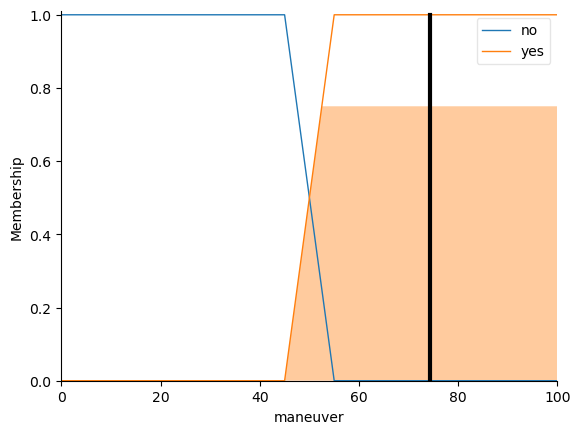

In [8]:
# calculates for values that require maneuvering
liquidcalc.compute()

print("Gravity: ", crisp_grav, "SG")
print("Velocity: ", crisp_vel, "OF")
print("Apoapsis: ", crisp_ap, "M")
print("Periapsis: ", crisp_per, "M")
print("Eccentricity: ", crisp_ecc)
print("Maneuver Threshold: ", liquidcalc.output['maneuver'])
print("Loss: ", get_mape(tests, ideals))

# computes and shows the fuzzy and crisp results
maneuver.view(sim=liquidcalc)

The Maneuver Threshold score of 74 is above the 50 threshold. The graph above illustrates a current state in which the spacecraft needs to rotate or accelerate in order to get closer to the ideal orbit state. The graph below, which has a score of 25 by contrast, represents the parameters of the ideal orbit state. 

Gravity:  1.0 SG
Velocity:  1.0 OF
Apoapsis:  200 M
Periapsis:  200 M
Eccentricity:  1.0
Maneuver Threshold:  25.08333333333333
Loss:  0.0


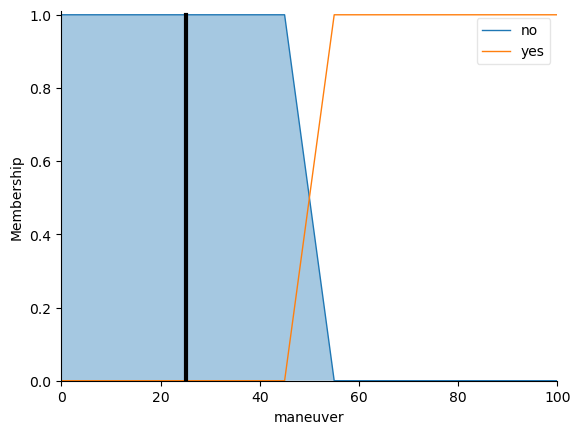

In [9]:
# calculates for ideal values
ideals = [1.0, 1.0, 200, 200, 1.0]

# ideal default crisp values
liquidcalc.input['gravity'] = 1.0
liquidcalc.input['velocity'] = 1.0
liquidcalc.input['apoapsis'] = 200
liquidcalc.input['periapsis'] = 200
liquidcalc.input['eccentricity'] = 1.0
liquidcalc.compute()

print("Gravity: ", 1.0, "SG")
print("Velocity: ", 1.0, "OF")
print("Apoapsis: ", 200, "M")
print("Periapsis: ", 200, "M")
print("Eccentricity: ", 1.0)
print("Maneuver Threshold: ", liquidcalc.output['maneuver'])
print("Loss: ", get_mape(ideals, ideals))

# computes and shows the fuzzy and crisp results
maneuver.view(sim=liquidcalc)

### Dynamic Regressor Neural Network

The Dynamic Regressor Neural network allows for the use of networks of varying shapes and sizes without the need to declare the shape beforehand. The flexibility of the dynamic network bypasses any errors associated with an incorrect shape declaration. The network takes in 5 features, a value that corresponds to the 5 spacecraft state parameters. The 5 hidden layers also correspond to the number of state parameters. This neural network returns 1 output value which determines what action the spacecraft will take in the reinforcemt learning loop. 

In [10]:
# initializes the Dymanic regressor net which allows for flexibility of size
class DynamicRegressorNet(torch.nn.Module):
    def __init__(self, n_hidden, n_output):
        super(DynamicRegressorNet, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=5, out_features=n_hidden)
        self.fc2 = torch.nn.Linear(in_features=n_hidden, out_features=n_output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The 'net' variable sets the number of hidden laters in the neural network. The 'learner' uses a learning rate of 0.03 which is the appropriate rate of change for the output of the network for this program. The 'loss_func' variable uses Torch's built-in Mean Absolute Error function to calculate the loss between the current state and ideal state. 

In [11]:
# initializes the net variable, 5 features for 5 variables
net = DynamicRegressorNet(n_hidden=5, n_output=1)
# lr is the learning rate (Alpha)
learner = torch.optim.SGD(net.parameters(), lr=0.03)

# declares the Mean Absolute Error
loss_func = torch.nn.L1Loss()

In [12]:
# function to obtain the 5 crisp values for the state
def get_state():
    return (crisp_grav, crisp_vel, crisp_ap, crisp_per, crisp_ecc)

The scale_and_shift function below multiplies the output of the Sigmoid, which has a value between 0 and 1, by a factor of 5 to account for the 5 possible actions. This value is used to determine what action the spacecraft will perform in the learning loop. 

In [13]:
# define a function to scale and shift the output to the desired range
# used after sigmiod activation function is applied to action
def scale_and_shift(output, min_val, max_val):
    scaled_output = (output * (max_val - min_val)) + min_val
    return scaled_output

### Planet/Rocket Parameters

The variables below serve as the global variables for the 2D Planet Orbiter game. The planet variables and spaceship variables serve as the basis for the calculation of the physics parameters of the game.

In [14]:
GREEN = (0, 255, 0)

# Load the background image
background_image = pygame.image.load("Textures/stars.jpg")
background_image = pygame.transform.scale(background_image, (800, 600))


# collection of possible planets
mercury = pygame.image.load('Textures/mercury.png')
venus = pygame.image.load('Textures/venus.png')
earth = pygame.image.load('Textures/earth.png')
luna = pygame.image.load('Textures/luna.png')
mars = pygame.image.load('Textures/mars.png')
jupiter = pygame.image.load('Textures/jupiter.png')
uranus = pygame.image.load('Textures/uranus.png')
neptune = pygame.image.load('Textures/neptune.png')
saturn = pygame.image.load('Textures/saturn.png')

planet_list = [mercury, venus, earth, luna, 
               mars, jupiter, uranus, neptune]
random_index = random.randint(0, 7)

# Planet attributes
G = 6.67430e-11  # gravitational constant 'G'
planet_mass = random.randint(50000000000000, 200000000000000)  # mass of planet
planet_radius = random.randint(100, 200)
planet_x, planet_y = 400, 300
planet = pygame.transform.scale(planet_list[random_index], (planet_radius*2, planet_radius*2))
gravitational_force = 0.0
orbit_height = planet_radius + 50

# Spaceship attributes
ship_mass = 1000 # mass of rocket
ship_width, ship_height = 60, 60
ship_x, ship_y = planet_x, ((planet_y/2) - (planet_radius - (planet_y/2)))
throttle = 0.0
ship = pygame.image.load('Textures/rocket.png')  # Load the ship image
ship = pygame.transform.scale(ship, (ship_width, ship_height))  # Resize if needed
ship_velocity = pygame.Vector2(0.0, 0.0)  # Initial velocity
# set to decimals to prevent rounding to whole numbers
ship_angle = 0


# gets the center of the planet and ship images
ship_rect = ship.get_rect()  # Get the rectangle of the ship image
ship_rect.center = (ship_x, ship_y)  # Set the initial ship position
planet_rect = planet.get_rect()  # Get the rectangle of the planet image
planet_rect.center = (planet_x+30, planet_y+30)  # Set the planet position

# Create a list to store the spaceship's positions for the path
ship_path = []
ship_distances = [155, 150]
# keeps track of ship's change in velocity
delta_v = 50

# tracks global orbital parameters
speed = 0
apoapsis = 155
periapsis = 150
major_axis = planet_radius
distance = 150

### 2D Planet Orbiter Game & Reinforcement Learning

The 2D Planet Orbiter game uses a series of physics calculations to determine the 5 current state parameters and the 5 ideal orbit parameters. The 5 current state values are inputted into the Dynamic Regressor Neural Network to determine the action value, a variable between 0 to 5 that determines that maneuver the spacecraft must perform. The Mean Absolute Error function determines the loss between the ideal orbit state and current state. 

In [ ]:
# runs the game

# Set up the display
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("Gravity Game")

clock = pygame.time.Clock()

pygame.init()

running = True
while running:
    # draws the background image
    screen.blit(background_image, (0, 0))

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
    # draws the planet and ship
    screen.blit(planet, planet_rect)  # Draw planet at its position
    screen.blit(ship, ship_rect)
	
	# saves a copy of the ship to rotate
    saved_image = pygame.image.load('Textures/rocket.png')  # Load the ship image
    saved_image = pygame.transform.scale(saved_image, (ship_width, ship_height))
    
    # tracks game time
    gtime = (pygame.time.get_ticks()) / 1000
    
    
    # function to reset game
    def reset_game():
        global ship_rect, ship_angle, ship, delta_v, ship_velocity, ship_distances
        ship_rect.center = (ship_x, ship_y)
        ship_velocity.x = 0.0
        ship_velocity.y = 0.0
        delta_v = 50
        
        # clears distances list, adds values to prevent zero list errors
        ship_distances = [155,150]
        
        # resets spin
        ship_angle = 0
        ship = pygame.transform.rotate(saved_image, ship_angle)
        ship_rect = ship.get_rect(center=ship_rect.center)
        
    # applies changes in velocity and delta v
    def apply_throttle():
        global delta_v, ship_velocity
        ship_velocity.x += throttle * math.cos(math.radians(ship_angle+90))
        ship_velocity.y += throttle * -math.sin(math.radians(ship_angle+90))
        delta_v = delta_v - throttle
        
    # function to rotate ship
    def rotate_ship(angle):
        global ship_rect, ship_angle, ship, delta_v
        ship_angle = ship_angle + angle
        ship = pygame.transform.rotate(saved_image, ship_angle)
        ship_rect = ship.get_rect(center=ship_rect.center) # re-centers ship spin
        delta_v = delta_v - (throttle/5)


    keys = pygame.key.get_pressed()
    # rotates ship
    if keys[pygame.K_a]:
        rotate_ship(10)
    if keys[pygame.K_d]:
        rotate_ship(-10)

    # moves ship
    if keys[pygame.K_w] and delta_v > 0:
        apply_throttle()
        
    # if spacebar is pressed
    if keys[pygame.K_SPACE]:
        # calls reset game function
        reset_game()

    # sets ship throttle
    if keys[pygame.K_UP]:
        throttle = throttle + 0.025
    if keys[pygame.K_DOWN]:
        throttle = throttle - 0.025
        
    # restricts thrust
    if throttle > 1:
    	throttle = 1
    if throttle < 0:
        throttle = 0
        
    # if fuel runs out
    if delta_v < 0:
        delta_v = 0.0
    
    
    # Update ship position based on its velocity
    ship_rect.x += ship_velocity.x
    ship_rect.y += ship_velocity.y
    
    # calculates gravity force on the ship based on the planet's mass
    direction = pygame.Vector2(planet_x - ship_rect.x, planet_y - ship_rect.y)
    distance = direction.length()
    ship_distances.append(distance)
    
    if distance > planet_radius and distance < 500:  # stops gravity at planet's surface
        direction.normalize_ip()
        gravitational_force = G * (planet_mass / distance**2)
        gravity = direction * gravitational_force
        ship_velocity.x += gravity.x
        ship_velocity.y += gravity.y
    
    elif distance > 500:
        # resets game
        reset_game()
    else:
        ship_velocity.x = 0.0
        ship_velocity.y = 0.0
    
    # Store the current position of the spaceship for the path
    ship_path.append((int(ship_rect.x+30), int(ship_rect.y+30)))
    
    # Limit the path length to avoid consuming too much memory
    if len(ship_path) > 2:  # Check for more than 2 points in the path
        # Draw the green path
        pygame.draw.lines(screen, GREEN, False, ship_path, 2)

        # Limit the path length to avoid consuming too much memory
        if len(ship_path) > 300:
            ship_path.pop(0)
        if len(ship_distances) > 300:
            ship_distances.pop(0)
    
    
    # keeps track of the ship parameters
    delta_v = round(delta_v, 3)
    percent_throttle = round(throttle*100, 3)
    path_array = np.array(ship_distances)
    altitude = round(distance, 3)
    
    # calculates specific energy of orbit E = (v^2 / 2) - ((G*M) / r)
    specific_energy = (speed**2 / 2) - ((G*planet_mass) / distance)
    semi_major_axis = - (G * planet_mass) / (2 * specific_energy)
    
    # calculates apoapsis and periapsis using specific energy and semi major axis
    periapsis = semi_major_axis * math.sqrt(1 + ((specific_energy*semi_major_axis) / (G*planet_mass)))
    # prevents periapsis from being negative or greater than apoapsis
    if periapsis < 0:
        periapsis = 0
    if periapsis > apoapsis:
        periapsis = apoapsis
        
    # ideal orbit goals
    gravity_goal = G * (planet_mass / orbit_height**2)
    orbit_goal = round(math.sqrt( (planet_mass * G) / orbit_height ), 3)
    # reinforcement learning parameters
    ideals = [gravity_goal, orbit_goal, orbit_height, orbit_height, 1.0]
    
    # keeps track of orbital parameters
    gravitational_force = round(gravitational_force, 3)
    speed = round(ship_velocity.length(), 3)
    apoapsis = round(np.max(path_array), 3)
    periapsis = round(periapsis, 3) # uses path array due to issues with calculations
    eccentricity = round((apoapsis-periapsis) / (apoapsis+periapsis), 3)
    
    
    # render text
    font = pygame.font.Font(None, 26)
    speed_text = font.render(f"Velocity (m/s): {speed}", True, (255, 255, 255))
    orbit_text = font.render(f"Orbit Goal (m/s): {orbit_goal}", True, (255, 255, 255))
    gravity_text = font.render(f"Gravity (m/s^2): {gravitational_force}", True, (255, 255, 255))
    delta_text = font.render(f"Delta-V (m/s): {delta_v}", True, (255, 255, 255))
    throttle_text = font.render(f"% Thrust: {percent_throttle}", True, (255, 255, 255))
    time_text = font.render(f"Time (s): {gtime}", True, (255, 255, 255))
    apoapsis_text = font.render(f"Apoapsis (m): {apoapsis}", True, (255, 255, 255))
    periapsis_text = font.render(f"Periapsis (m): {periapsis}", True, (255, 255, 255))
    eccentricity_text = font.render(f"Eccentricity: {eccentricity}", True, (255, 255, 255))
    altitude_text = font.render(f"Altitude: {altitude}", True, (255, 255, 255))
    
    # displays speed text on the screen
    screen.blit(speed_text, (10, 10))
    screen.blit(gravity_text, (10, 30))
    screen.blit(orbit_text, (10, 50))
    screen.blit(delta_text, (10, 70))
    screen.blit(throttle_text, (10, 90))
    screen.blit(time_text, (600, 10))
    screen.blit(apoapsis_text, (600, 30))
    screen.blit(periapsis_text, (600, 50))
    screen.blit(eccentricity_text, (600, 70))
    screen.blit(altitude_text, (600, 90))
    
    
    # runs reinforcement learning for 120 seconds
    if gtime < 120:
        
        # gets the current state of the 5 crisp values
        state = [gravitational_force, speed, apoapsis, periapsis, (1-eccentricity)]
        crisp_grav, crisp_vel, crisp_ap, crisp_per, crisp_ecc = gravitational_force, speed, apoapsis, periapsis, (1-eccentricity)
        
        # applies sigmoid activation function to restrict numerical range of action
        action = torch.sigmoid(net(torch.Tensor(state)))
        scaled_action = scale_and_shift(action, min_val=0, max_val=5)
        action_float = scaled_action.item()
        
        
        # applies an action depending on the action float value
        if action_float < 1:
            print("rotate right")
            rotate_ship(-10)
        if action_float > 1 and action_float < 2:
            print("rotate left")
            rotate_ship(10)
        if action_float > 2 and action_float < 3:
            print("throttle down")
            throttle = throttle - 0.025
        if action_float > 3 and action_float < 4:
            print("throttle up")
            throttle = throttle + 0.025
        if action_float > 4 and action_float <= 5.0:
            print("apply throttle")
            apply_throttle()
        
        
        
        # compute the loss (reward) based on the updated crisp variables
        new_state = get_state()
        reward = get_mape(new_state, ideals)

        # update the neural network based on the reward
        loss = loss_func(net(torch.Tensor(new_state)), torch.Tensor([reward]))
        learner.zero_grad()
        loss.backward()
        learner.step()

        print("Action: ", action_float)
        
    # resets game after 120 seconds    
    if gtime > 120 and gtime < 120.04:
        
        # stores current orbital parameters as crisp valaues
        crisp_grav, crisp_vel, crisp_ap, crisp_per, crisp_ecc = gravitational_force, speed, apoapsis, periapsis, (1-eccentricity)
        final_state = get_state()
        
        # updates fuzzy logic parameters
        liquidcalc.input['gravity'] = crisp_grav
        liquidcalc.input['velocity'] = crisp_vel
        liquidcalc.input['apoapsis'] = crisp_ap
        liquidcalc.input['periapsis'] = crisp_per
        liquidcalc.input['eccentricity'] = crisp_ecc
        liquidcalc.compute() # calculates maneuver threshold
        
        # prints crisp values
        print("Gravity: ", crisp_grav, "SG")
        print("Velocity: ", crisp_vel, "OF")
        print("Apoapsis: ", crisp_ap, "M")
        print("Periapsis: ", crisp_per, "M")
        print("Eccentricity: ", 1-crisp_ecc)
        print("Maneuver Threshold: ", liquidcalc.output['maneuver'])
        print("Loss: ", get_mape(final_state, ideals))

    pygame.display.update()
    clock.tick(30)

pygame.quit()

rotate right
Action:  1.734898447125488e-08
apply throttle
Action:  5.0
throttle down
Action:  2.490799903869629
throttle down
Action:  2.528298854827881
throttle down
Action:  2.5657849311828613
throttle down
Action:  2.603241443634033
throttle down
Action:  2.6406514644622803
throttle down
Action:  2.6779983043670654
throttle down
Action:  2.7152657508850098
throttle down
Action:  2.752437114715576
throttle down
Action:  2.7894954681396484
throttle down
Action:  2.826425790786743
throttle down
Action:  2.8632116317749023
throttle down
Action:  2.8998377323150635
throttle down
Action:  2.936288356781006
throttle down
Action:  2.972548484802246
throttle up
Action:  3.008603811264038
throttle up
Action:  3.0444397926330566
throttle up
Action:  3.0800418853759766
throttle up
Action:  3.1153976917266846
throttle up
Action:  3.1504931449890137
throttle up
Action:  3.1853156089782715
throttle up
Action:  3.219853401184082
throttle up
Action:  3.254093647003174
throttle up
Action:  3.2880256

apply throttle
Action:  4.987545490264893
apply throttle
Action:  4.987912654876709
apply throttle
Action:  4.988269329071045
apply throttle
Action:  4.988615036010742
apply throttle
Action:  4.988951206207275
apply throttle
Action:  4.989276885986328
apply throttle
Action:  4.989593505859375
apply throttle
Action:  4.9899001121521
apply throttle
Action:  4.990198135375977
apply throttle
Action:  4.990487575531006
apply throttle
Action:  4.990767478942871
apply throttle
Action:  4.991040229797363
apply throttle
Action:  4.991304397583008
apply throttle
Action:  4.991560935974121
apply throttle
Action:  4.991809844970703
apply throttle
Action:  4.992051601409912
apply throttle
Action:  4.992286682128906
apply throttle
Action:  4.992514133453369
apply throttle
Action:  4.992734432220459
apply throttle
Action:  4.99294900894165
apply throttle
Action:  4.993156909942627
apply throttle
Action:  4.993359565734863
apply throttle
Action:  4.993555545806885
apply throttle
Action:  4.99374580383

apply throttle
Action:  4.999964714050293
apply throttle
Action:  4.999966144561768
apply throttle
Action:  4.999967098236084
apply throttle
Action:  4.999967575073242
apply throttle
Action:  4.999969005584717
apply throttle
Action:  4.999970436096191
apply throttle
Action:  4.99997091293335
apply throttle
Action:  4.999971866607666
apply throttle
Action:  4.999972343444824
apply throttle
Action:  4.999973297119141
apply throttle
Action:  4.999974250793457
apply throttle
Action:  4.999975204467773
apply throttle
Action:  4.999975681304932
apply throttle
Action:  4.99997615814209
apply throttle
Action:  4.999977111816406
apply throttle
Action:  4.999978065490723
apply throttle
Action:  4.999978542327881
apply throttle
Action:  4.999979019165039
apply throttle
Action:  4.9999799728393555
apply throttle
Action:  4.999980449676514
apply throttle
Action:  4.999980926513672
apply throttle
Action:  4.99998140335083
apply throttle
Action:  4.999981880187988
apply throttle
Action:  4.9999828338

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply t

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio

apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Action:  5.0
apply throttle
Actio